In [158]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import datetime

## WHO - global influenza occurences
The WHO reports Influenza occurences for all around the world on a weekly basis. It is expected that due to spreading patterns of influenza waves throughout the world, influenza waves different countries can be used as an indicator for the prediction of influenza waves for Germany. The data for the **Influenza transmission zone** South West Europe is analysed below 

Note: The influenza transmission zones join geographically related countries or territories to larger areas that have similar influenza transmission patterns so that an overview can be given. www.who.int/csr/.../swineflu/Influenza_Transmission_Zones.pdf


In [6]:
df_who_global = pd.read_csv('FluNetInteractiveReport.csv',skiprows=3,parse_dates=['SDATE','EDATE']).fillna(value = 0)
df_who_global.head(5)


,Country,WHOREGION,FLUREGION,Year,Week,SDATE,EDATE,SPEC_RECEIVED_NB,SPEC_PROCESSED_NB,AH1,...,AH5,ANOTSUBTYPED,INF_A,BYAMAGATA,BVICTORIA,BNOTDETERMINED,INF_B,ALL_INF,ALL_INF2,TITLE
0,Albania,European Region of WHO,South West Europe,1997,1,1996-12-30,1997-01-05,0.0,0.0,0.0,...,0.0,0.0,0,0.0,0.0,0.0,0,0,0.0,No Report
1,Albania,European Region of WHO,South West Europe,1997,3,1997-01-13,1997-01-19,0.0,0.0,0.0,...,0.0,0.0,0,0.0,0.0,0.0,0,0,0.0,No Report
2,Albania,European Region of WHO,South West Europe,1997,16,1997-04-14,1997-04-20,0.0,0.0,0.0,...,0.0,0.0,0,0.0,0.0,0.0,0,0,0.0,No Report
3,Albania,European Region of WHO,South West Europe,1998,5,1998-01-26,1998-02-01,0.0,0.0,0.0,...,0.0,0.0,0,0.0,0.0,0.0,0,0,0.0,No Report
4,Albania,European Region of WHO,South West Europe,1998,6,1998-02-02,1998-02-08,0.0,0.0,0.0,...,0.0,0.0,0,0.0,0.0,0.0,0,0,0.0,No Report


['Country', 'WHOREGION', 'FLUREGION', 'Year', 'Week', 'SDATE', 'EDATE', 'SPEC_RECEIVED_NB', 'SPEC_PROCESSED_NB', 'AH1', 'AH1N12009', 'AH3', 'AH5', 'ANOTSUBTYPED', 'INF_A', 'BYAMAGATA', 'BVICTORIA', 'BNOTDETERMINED', 'INF_B', 'ALL_INF', 'ALL_INF2', 'TITLE']


Text(0,0.5,u'# detected Influenza viruses (A+B)')

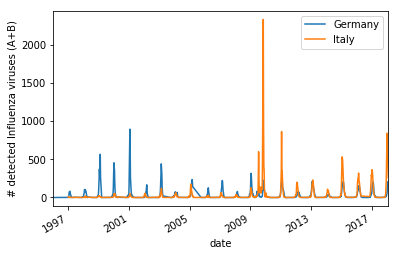

In [174]:
print(list(df_who_global))

df_2years_G_F_I = df_who_global.loc[df_who_global['Country'].isin(['Germany','Italy'])&(df_who_global['SDATE']>='1995-12-01')]

df_2years_G_F_I.set_index('SDATE',inplace=True)
fig = plt.figure()
df_2years_G_F_I.groupby('Country')['ALL_INF'].plot(legend = True)

plt.xlabel('date')
plt.ylabel('# detected Influenza viruses (A+B)')

#plt.savefig('InfluenzaDetectionsOverTime_France_Germany_Italy.eps')


In [86]:
df_inf_per_state=df_who_global.pivot(index='EDATE', columns='Country', values='ALL_INF')
df_inf_per_state.rename(columns={'United Kingdom of Great Britain and Northern Ireland':'UK'}, inplace=True)

print(list(df_inf_per_state))
df_inf_per_state.tail()

['Albania', 'Armenia', 'Austria', 'Azerbaijan', 'Belarus', 'Belgium', 'Bosnia and Herzegovina', 'Bulgaria', 'Croatia', 'Cyprus', 'Czechia', 'Denmark', 'Estonia', 'Finland', 'France', 'Georgia', 'Germany', 'Greece', 'Hungary', 'Iceland', 'Ireland', 'Israel', 'Italy', 'Kazakhstan', 'Kosovo (in accordance with Security Council resolution 1244 (1999))', 'Kyrgyzstan', 'Latvia', 'Lithuania', 'Luxembourg', 'Malta', 'Montenegro', 'Netherlands', 'Norway', 'Poland', 'Portugal', 'Republic of Moldova', 'Romania', 'Russian Federation', 'Serbia', 'Slovakia', 'Slovenia', 'Spain', 'Sweden', 'Switzerland', 'Tajikistan', 'The former Yugoslav Republic of Macedonia', 'Turkey', 'Turkmenistan', 'Ukraine', 'UK', 'Uzbekistan']


Country,Albania,Armenia,Austria,Azerbaijan,Belarus,Belgium,Bosnia and Herzegovina,Bulgaria,Croatia,Cyprus,...,Spain,Sweden,Switzerland,Tajikistan,The former Yugoslav Republic of Macedonia,Turkey,Turkmenistan,Ukraine,UK,Uzbekistan
EDATE,,,,,,,,,,,,,,,,,,,,,
2018-01-14,16.0,32.0,310.0,10.0,2.0,21.0,NaN,49.0,207.0,3.0,...,1369.0,635.0,993.0,2.0,6.0,201.0,NaN,10.0,4048.0,0.0
2018-01-21,35.0,19.0,482.0,NaN,0.0,8.0,NaN,97.0,195.0,8.0,...,1400.0,747.0,1017.0,0.0,1.0,224.0,NaN,9.0,3695.0,2.0
2018-01-28,47.0,18.0,650.0,0.0,0.0,36.0,NaN,123.0,201.0,4.0,...,1192.0,1116.0,1039.0,3.0,8.0,210.0,NaN,25.0,3542.0,2.0
2018-02-04,82.0,21.0,667.0,3.0,6.0,14.0,NaN,54.0,215.0,NaN,...,821.0,1522.0,598.0,1.0,13.0,100.0,NaN,37.0,3119.0,1.0
2018-02-11,71.0,24.0,742.0,11.0,11.0,NaN,NaN,39.0,199.0,NaN,...,738.0,1779.0,74.0,NaN,51.0,120.0,NaN,82.0,2508.0,3.0


## Cross-correlation of influenza cases reported from European countries


In the following, the cross-correlation of the influenza cases reported in Germany and in other European countries is investigated for different time-lags, that may indicate the delay of the flu wave between the countries. 



In [111]:
def crosscorr(datax, datay, lag=0):
    return datax.corr(datay.shift(lag))   #pandas.Series.corr (Pearson correlation coefficient)


timelag=range(-5,10,1)

df_crosscorr=pd.DataFrame(index=timelag)
df_crosscorr_summary=pd.DataFrame(index=['max', 'shift [w]'])

for column in df_inf_per_state:
    xcov_weekly = [crosscorr(df_inf_per_state['Germany'],df_inf_per_state[column], lag=i) for i in timelag]
    df_crosscorr[column] = xcov_weekly
    df_crosscorr_summary[column]=[max(xcov_weekly), timelag[xcov_weekly.index(max(xcov_weekly))]]
 

df_crosscorr_summary.loc[:,['Italy','Austria','UK', 'Switzerland','France', 'Spain', 'Poland', 'Netherlands', 'Sweden']]


,Italy,Austria,UK,Switzerland,France,Spain,Poland,Netherlands,Sweden
max,0.296971,0.383513,0.303491,0.305187,0.82672,0.321158,0.30367,0.366367,0.41435
shift [w],1.000000,1.000000,3.000000,2.000000,2.00000,2.000000,0.00000,1.000000,1.00000


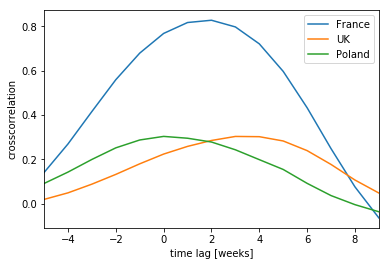

In [110]:
#plt.plot(timelag, df_crosscorr['France'])
df_crosscorr.reset_index().plot(x='index', y=['France', 'UK', 'Poland'])
plt.xlabel('time lag [weeks]')
plt.ylabel('crosscorrelation')
plt.legend()
plt.show()


Text(0.5,1,u'Poland')

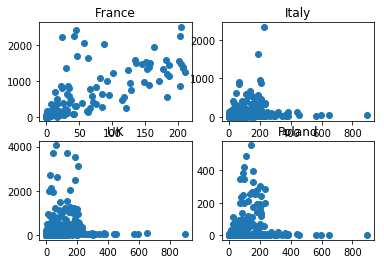

In [173]:
from datetime import timedelta

countries=['France','Italy','UK','Poland']
lag=0
d=datetime.timedelta(weeks=lag)

plt.subplot(221)
plt.scatter(df_inf_per_state.loc[(df_inf_per_state.index.min()+d):,'Germany'], df_inf_per_state.loc[:(df_inf_per_state.index.max()-d),countries[0]])
plt.title(countries[0])

plt.subplot(222)
plt.scatter(df_inf_per_state.loc[(df_inf_per_state.index.min()+d):,'Germany'], df_inf_per_state.loc[:(df_inf_per_state.index.max()-d),countries[1]])
plt.title(countries[1])

plt.subplot(223)
plt.scatter(df_inf_per_state.loc[(df_inf_per_state.index.min()+d):,'Germany'], df_inf_per_state.loc[:(df_inf_per_state.index.max()-d),countries[2]])
plt.title(countries[2])

plt.subplot(224)
plt.scatter(df_inf_per_state.loc[(df_inf_per_state.index.min()+d):,'Germany'], df_inf_per_state.loc[:(df_inf_per_state.index.max()-d),countries[3]])
plt.title(countries[3])


nan

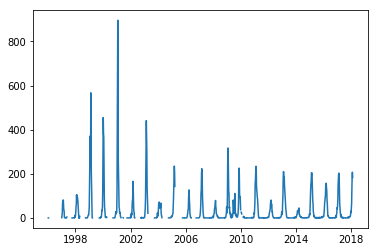

In [142]:
import numpy as np
from scipy import stats

x=df_inf_per_state.index.values
y=df_inf_per_state['Germany'].as_matrix()
not_nan_ind = ~np.isnan(y)
#m, b, r_val, p_val, std_err = stats.linregress(x[not_nan_ind],y[not_nan_ind])
#detrend_y = y - (m*x + b)
plt.plot(x,y)

df_inf_per_state['Germany']

In [113]:
#detrending the data

from scipy import signal

df_inf_per_state_detr=pd.DataFrame()

x=df_inf_per_state.index.values

for column in df_inf_per_state:
    #df_inf_per_state_detr[column] = signal.detrend(df_inf_per_state[column])
    y=df_inf_per_state[column]
    not_nan_ind = ~np.isnan(y)
    m, b, r_val, p_val, std_err = stats.linregress(x[not_nan_ind],y[not_nan_ind])
    detrend_y = y - (m*x + b)


signal.detrend(x)

ValueError: array must not contain infs or NaNs

## Google trend data

Google trend data is expected to give a good estimator of the current influenza situation in a country. It's quality for medium and long term are questionable. 